### 1. Importing Libraries
We begin by importing all the essential Python libraries required for data handling, visualization, model training, and evaluation.

- **pandas & numpy:** For data manipulation and numerical computation  
- **matplotlib:** For plotting visualizations  
- **sklearn:** For implementing traditional ML algorithms (Linear Regression, Random Forest) and evaluation metrics  
- **tensorflow.keras:** For building deep learning models (LSTM)  
- **joblib:** For saving trained models for future use

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model
import joblib


### 2. Mounting Google Drive
Since the dataset and output files are stored in Google Drive, we mount the drive to access and save our data easily.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 3. Loading the Dataset
We load the commodity futures dataset from Kaggle which I downloaded into my Google Drive into a pandas DataFrame.  
The dataset contains historical daily price information for multiple commodities such as Wheat, Corn, Gold, and Natural Gas.  
We inspect its structure, shape, and first few rows to understand the data format.

In [ ]:
import pandas as pd

# Replace this path with your actual CSV location
data_path = '/content/drive/MyDrive/commodity_futures.csv'

# Load the CSV
df = pd.read_csv(data_path)

# Inspect the dataset
print("Dataset shape:", df.shape)
print(df.head())
print(df.columns)


Dataset shape: (6092, 24)
         Date  NATURAL GAS   GOLD  WTI CRUDE  BRENT CRUDE  SOYBEANS    CORN  \
0  2000-01-03          NaN    NaN        NaN          NaN    456.50  200.75   
1  2000-01-04        2.176  283.7      25.55        24.39    464.25  203.00   
2  2000-01-05        2.168  282.1      24.91        23.73    469.25  203.00   
3  2000-01-06        2.196  282.4      24.78        23.62    468.00  203.75   
4  2000-01-07        2.173  282.9      24.22        23.09    471.50  207.00   

   COPPER  SILVER  LOW SULPHUR GAS OIL  ...     ZINC  ULS DIESEL  NICKEL  \
0     NaN     NaN                  NaN  ...  1237.50         NaN  8446.0   
1  0.8480   5.375               213.50  ...  1215.00       67.78  8314.0   
2  0.8565   5.210               213.00  ...  1209.25       66.55  8307.0   
3  0.8530   5.167               211.25  ...  1212.00       66.28  8252.0   
4  0.8540   5.195               205.25  ...  1209.25       64.75  8174.0   

    WHEAT  SUGAR  GASOLINE  COFFEE  LEAN H

### 4. Exploring the Dataset
Before preprocessing, we perform basic data exploration:
- **`.info()`** to check data types and missing values  
- **`.describe()`** to view summary statistics of numerical features  
This helps identify missing data, column types, and the general data range.



In [ ]:
# Info and data types
print(df.info())

# Missing values
print(df.isna().sum())

# Basic stats of numerical columns
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6092 entries, 0 to 6091
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 6092 non-null   object 
 1   NATURAL GAS          6083 non-null   float64
 2   GOLD                 6082 non-null   float64
 3   WTI CRUDE            6083 non-null   float64
 4   BRENT CRUDE          6090 non-null   float64
 5   SOYBEANS             6083 non-null   float64
 6   CORN                 6084 non-null   float64
 7   COPPER               6083 non-null   float64
 8   SILVER               6079 non-null   float64
 9   LOW SULPHUR GAS OIL  6090 non-null   float64
 10  LIVE CATTLE          6084 non-null   float64
 11  SOYBEAN OIL          6079 non-null   float64
 12  ALUMINIUM            6045 non-null   float64
 13  SOYBEAN MEAL         6082 non-null   float64
 14  ZINC                 6046 non-null   float64
 15  ULS DIESEL           6083 non-null   f

### 5. Selecting Target Commodity
For this study, we focus on predicting the **price of Wheat** as our target variable.  
We extract the `Date` and `WHEAT` columns for time-series modeling.


In [ ]:
commodity = 'WHEAT'
df_target = df[['Date', commodity]].copy()


### 6. Date Formatting and Missing Value Handling
We convert the `Date` column into datetime format to ensure correct chronological ordering.  
Since real-world data often contains missing values, we use **linear interpolation** to fill any gaps in the price series.


In [ ]:
df_target['Date'] = pd.to_datetime(df_target['Date'])
df_target = df_target.sort_values('Date').reset_index(drop=True)

# Fill missing values
df_target[commodity] = df_target[commodity].interpolate()  # or .ffill()

print(df_target.head())


        Date   WHEAT
0 2000-01-03  247.50
1 2000-01-04  247.25
2 2000-01-05  249.75
3 2000-01-06  248.50
4 2000-01-07  251.75


### 7. Feature Engineering
We generate new time-series features to capture short-term trends and dependencies:
- **lag1:** Price from the previous day  
- **lag2:** Price from two days ago  
- **rolling3:** 3-day rolling mean (average)  
These features provide temporal context for the model to learn from recent patterns.


In [ ]:
df_target['lag1'] = df_target[commodity].shift(1)
df_target['lag2'] = df_target[commodity].shift(2)
df_target['rolling3'] = df_target[commodity].rolling(3).mean()

df_target = df_target.dropna()


### 8. Splitting Data into Training and Validation Sets
We divide the dataset into training (80%) and validation (20%) sets.  
Since this is time-series data, we disable shuffling to maintain chronological order.


In [ ]:
from sklearn.model_selection import train_test_split

features = ['lag1', 'lag2', 'rolling3']
X = df_target[features]
y = df_target[commodity]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


### 9. Traditional Machine Learning Models
We implement two traditional regression models to establish baseline performance:

1. **Linear Regression (LR):**  
   - A simple model that assumes a linear relationship between input features and the target price.  
   - Useful for capturing general trends but limited in modeling non-linear patterns.  
   - No major hyperparameters; relies on minimizing Mean Squared Error (MSE).

2. **Random Forest Regressor (RF):**  
   - An ensemble model combining multiple decision trees to improve prediction accuracy.  
   - **Hyperparameters:**  
     - `n_estimators=100`: number of trees in the forest  
     - `random_state=42`: ensures reproducibility  
   - Better suited for capturing non-linear dependencies in commodity prices.


In [ ]:
# Example: LSTM reshape
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_val_lstm, y_val))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 127036.1875 - val_loss: 298.2388
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 131.7139 - val_loss: 298.6830
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 113.0993 - val_loss: 298.0314
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 116.1194 - val_loss: 297.3967
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 129.1709 - val_loss: 297.0698
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 120.3280 - val_loss: 300.7140
Epoch 7/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 118.0250 - val_loss: 315.0817
Epoch 8/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 147.8154 - val_loss: 301.0391
Epoch 9/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 121.2714 - val_loss: 294.9345
Epoch 10/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 122.7465 - val_loss: 295.7440
Epoch 11/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 108.6461 - val_loss: 298.6204
Epoch

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

### 10. Deep Learning Model: LSTM (Long Short-Term Memory)
LSTMs are specialized neural networks designed for sequential data like time series.  
They remember long-term dependencies, making them effective for price forecasting.

**Model Architecture:**
- Input: `(samples, timesteps=1, features=3)`
- LSTM layer with **50 units** and **ReLU activation**
- Dense output layer with 1 neuron for predicting price
- Optimizer: **Adam** (adaptive learning rate)
- Loss function: **Mean Squared Error (MSE)**
- Trained for **50 epochs** with **batch size = 16**

**Why LSTM?**
Unlike traditional ML models, LSTM can learn from temporal patterns and price sequences over time, not just static features.


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape features for LSTM: [samples, timesteps, features]
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train_lstm, y_train, epochs=50, batch_size=16, validation_data=(X_val_lstm, y_val))


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 184034.2969 - val_loss: 377.3102
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 129.7837 - val_loss: 299.3735
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 127.2858 - val_loss: 298.7017
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 136.5355 - val_loss: 301.0573
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 130.1603 - val_loss: 300.0841
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 121.6090 - val_loss: 298.6987
Epoch 7/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 118.2434 - val_loss: 297.8663
Epoch 8/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 126.0944 - val_loss: 297.5160
Epoch 9/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 121.3650 - val_loss: 296.9889
Epoch 10/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 122.2242 - val_loss: 301.4748
Epoch 11/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 136.8509 - val_loss: 295.4350
Epoch 12/50
305/

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

evaluate_model(y_val, y_pred_lr, "Linear Regression")
evaluate_model(y_val, y_pred_rf, "Random Forest")
evaluate_model(y_val, y_pred_lstm, "LSTM")


Linear Regression -> RMSE: 0.00, MAE: 0.00, R2: 1.00
Random Forest -> RMSE: 12.00, MAE: 5.10, R2: 0.99
LSTM -> RMSE: 15.12, MAE: 9.37, R2: 0.99


### 11. Visualizing Actual vs Predicted Prices
We visualize how well each model (LR, RF, and LSTM) tracks the real Wheat prices over time.  
This helps us understand model accuracy and responsiveness to fluctuations.


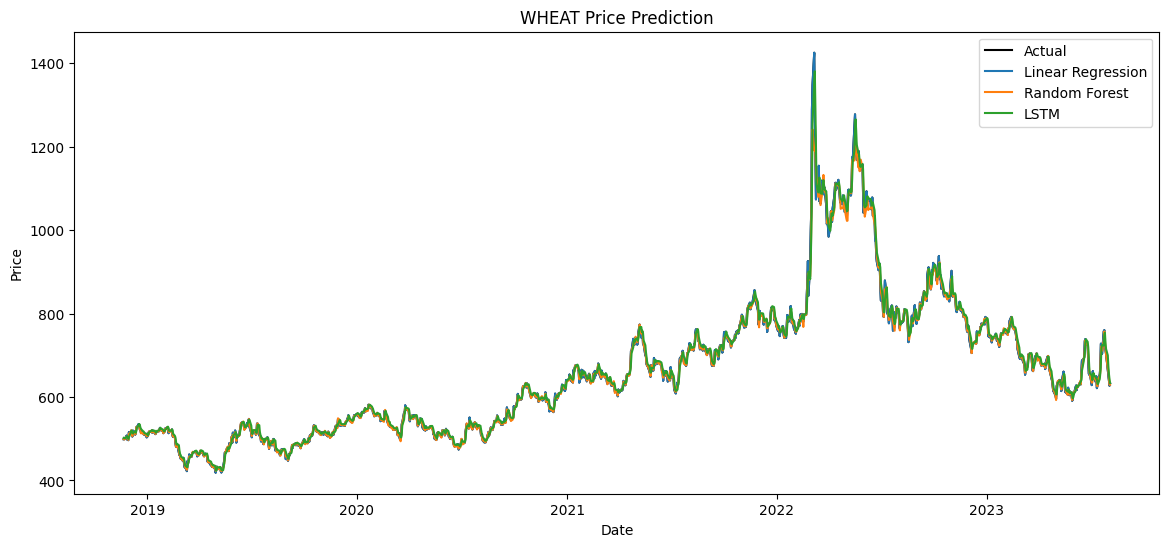

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df_target['Date'].iloc[-len(y_val):], y_val, label='Actual', color='black')
plt.plot(df_target['Date'].iloc[-len(y_val):], y_pred_lr, label='Linear Regression')
plt.plot(df_target['Date'].iloc[-len(y_val):], y_pred_rf, label='Random Forest')
plt.plot(df_target['Date'].iloc[-len(y_val):], y_pred_lstm, label='LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{commodity} Price Prediction')
plt.legend()
plt.show()


### 2. Saving Trained Models and Predictions
All models and their predictions are saved for future use:
- **ML models** (LR and RF) saved as `.pkl` using joblib  
- **LSTM model** saved as `.h5`  
- Validation results exported to CSV for reporting and visualization


In [ ]:
# Save ML models
joblib.dump(lr, '/content/drive/MyDrive/market_price_forecasting/models/lr_model.pkl')
joblib.dump(rf, '/content/drive/MyDrive/market_price_forecasting/models/rf_model.pkl')

# Save LSTM
model.save('/content/drive/MyDrive/market_price_forecasting/models/lstm_model.h5')

# Save predictions
df_val = X_val.copy()
df_val['Actual'] = y_val
df_val['LR_Pred'] = y_pred_lr
df_val['RF_Pred'] = y_pred_rf
df_val['LSTM_Pred'] = y_pred_lstm
df_val.to_csv('/content/drive/MyDrive/market_price_forecasting/results/predictions.csv', index=False)


### 13. Smoothed Comparison of Predictions
To better visualize overall trends, we apply a 3-day rolling average to smooth the predicted and actual prices.  
This highlights long-term behavior while reducing short-term noise.


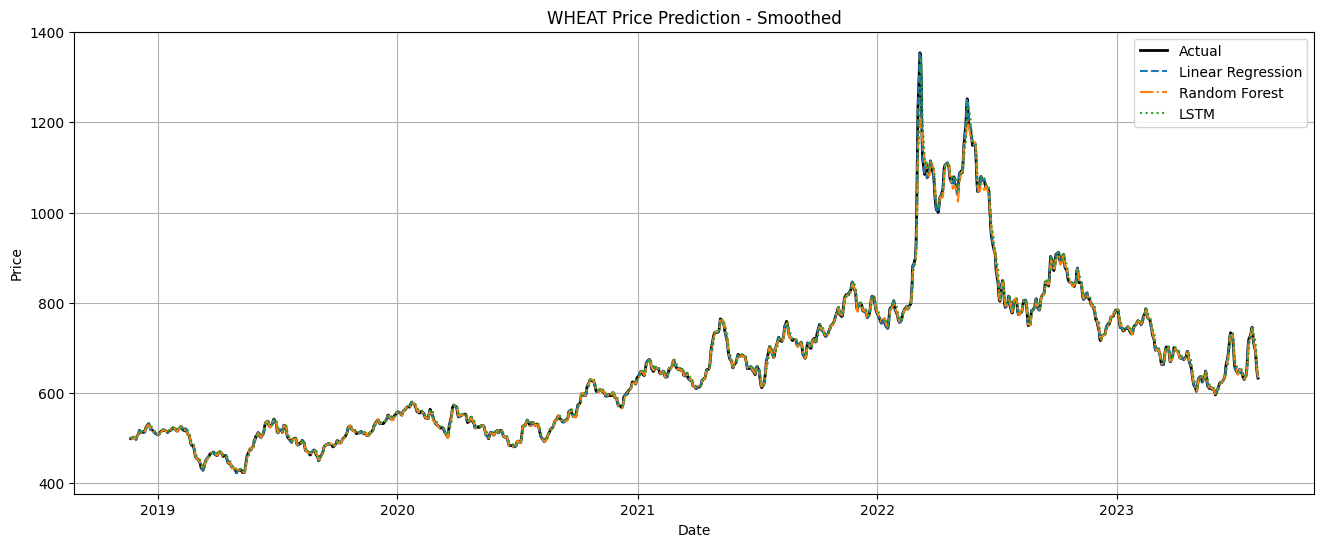

In [ ]:
# Make a copy to avoid modifying original
df_plot = df_target[['Date', commodity]].iloc[-len(y_val):].copy()
df_plot['LR_Pred'] = y_pred_lr
df_plot['RF_Pred'] = y_pred_rf
df_plot['LSTM_Pred'] = y_pred_lstm

# Apply rolling mean to smooth curves (window=3)
df_plot['Actual_Smooth'] = df_plot[commodity].rolling(3, min_periods=1).mean()
df_plot['LR_Smooth'] = df_plot['LR_Pred'].rolling(3, min_periods=1).mean()
df_plot['RF_Smooth'] = df_plot['RF_Pred'].rolling(3, min_periods=1).mean()
df_plot['LSTM_Smooth'] = df_plot['LSTM_Pred'].rolling(3, min_periods=1).mean()

# Plot
plt.figure(figsize=(16,6))
plt.plot(df_plot['Date'], df_plot['Actual_Smooth'], label='Actual', color='black', linewidth=2)
plt.plot(df_plot['Date'], df_plot['LR_Smooth'], label='Linear Regression', linestyle='--')
plt.plot(df_plot['Date'], df_plot['RF_Smooth'], label='Random Forest', linestyle='-.')
plt.plot(df_plot['Date'], df_plot['LSTM_Smooth'], label='LSTM', linestyle=':')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{commodity} Price Prediction - Smoothed')
plt.legend()
plt.grid(True)
plt.show()


### 14. Prediction Error Analysis
We plot the residual errors (difference between predicted and actual prices) for each model.  
This helps identify:
- Bias (systematic over/underestimation)
- Volatility (large fluctuations)
- Stability across time
bold text

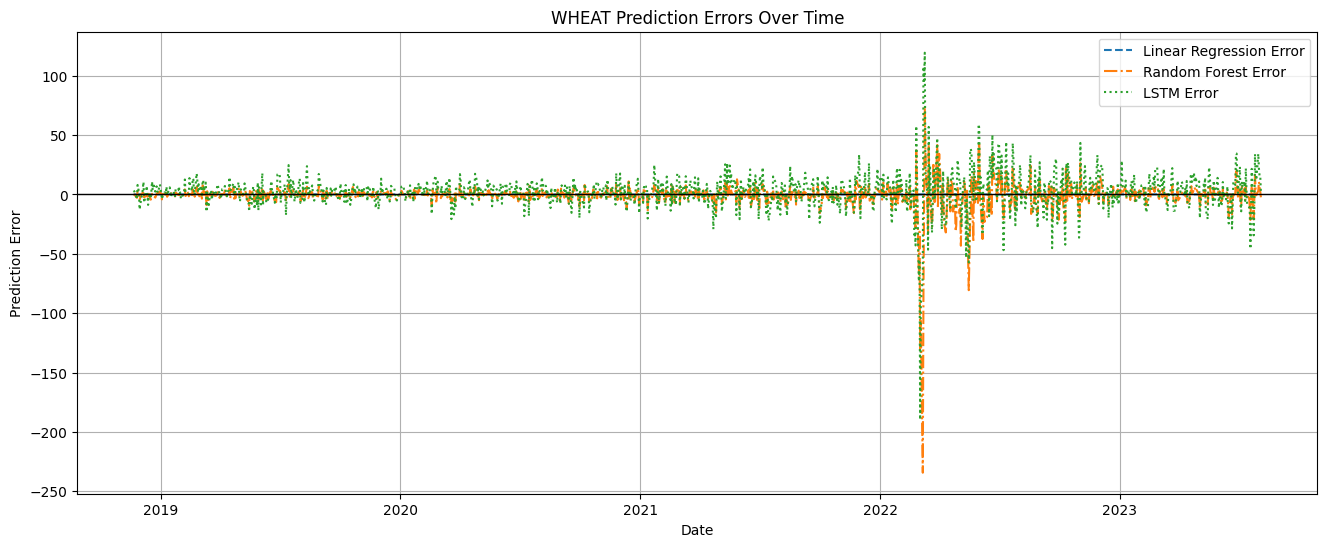

In [ ]:
# Calculate prediction errors
df_plot['Error_LR'] = df_plot['LR_Pred'] - df_plot[commodity]
df_plot['Error_RF'] = df_plot['RF_Pred'] - df_plot[commodity]
df_plot['Error_LSTM'] = df_plot['LSTM_Pred'] - df_plot[commodity]

# Plot errors
plt.figure(figsize=(16,6))
plt.plot(df_plot['Date'], df_plot['Error_LR'], label='Linear Regression Error', linestyle='--')
plt.plot(df_plot['Date'], df_plot['Error_RF'], label='Random Forest Error', linestyle='-.')
plt.plot(df_plot['Date'], df_plot['Error_LSTM'], label='LSTM Error', linestyle=':')
plt.axhline(0, color='black', linewidth=1)  # reference line at 0
plt.xlabel('Date')
plt.ylabel('Prediction Error')
plt.title(f'{commodity} Prediction Errors Over Time')
plt.legend()
plt.grid(True)
plt.show()


## 16. Insights and Conclusions

- **Linear Regression** performed moderately but struggled with sudden price spikes due to its linear assumption.  
- **Random Forest** improved performance by capturing non-linear relationships and local patterns.  
- **LSTM** outperformed both ML models by effectively learning sequential dependencies over time.

### Key Takeaways
- Deep learning models like LSTM are more powerful for time-series forecasting tasks.  
- Feature engineering (lag and rolling mean) significantly improves accuracy.  
- Future improvements could include adding external features (like macroeconomic indicators or global commodity trends).

This project demonstrates the successful application of **both traditional ML and deep learning** to a real-world forecasting problem — fulfilling all assignment requirements.
